In [4]:
import torch

import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader

import numpy as np

from PIL import Image
import matplotlib.pyplot as plt

import glob

import os

In this notebook we resize our data and then augment it.

## Getting the data

In [5]:
class config:
    BASE_PATH = "../input/msc-ai-2022/"
    TRAIN_IMG_PATH = "/kaggle/input/msc-ai-2022/train_images/train_images"
    TRAIN_MASK_PATH = "/kaggle/input/msc-ai-2022/train_masks/train_masks"
    TEST_IMG_PATH = "/kaggle/input/msc-ai-2022/test_images/test_images"

In [6]:
HEIGHT = 256
WIDTH = 256
BATCH_SIZE = 8


# Create a custom Dataset class
class tensorDataset(Dataset):
    def __init__(self, image_paths: list, mask_paths: list, train: bool):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.train = train
        
        self.transform_img = transforms.Compose([
            transforms.Resize([HEIGHT,WIDTH]),
            transforms.ToTensor()
        ])
        self.transform_mask = transforms.Compose([
            transforms.Resize([HEIGHT,WIDTH], interpolation = transforms.InterpolationMode.NEAREST), # Important
            transforms.ToTensor()
        ])
        
    def __getitem__(self, index):
        
        # Select a specific image's path
        img_path  = self.image_paths[index]
        mask_path = self.mask_paths[index]
        
        # Load the image
        img = Image.open(img_path)
        mask = Image.open(mask_path)
    
        # Apply transformations
        img = self.transform_img(img)
        mask = self.transform_mask(mask)
        
        # Scale the mask from 0-1 range to 0-255 range
        mask = mask * 255  
        
        # Reshape mask from (1, H, W) to (H, W) -> This is because loss function accepts (B, H, W) not (B, 1, H, W)
        mask = mask.squeeze(0)
        
        return img, mask

    def __len__(self):
        return len(self.image_paths)

In [7]:
# Very simple train/test split
train_ratio = 0.8
train_set_last_idx = int(len(glob.glob(config.TRAIN_IMG_PATH + "/*")) * train_ratio)

train_img_paths  = sorted(glob.glob(config.TRAIN_IMG_PATH + "/*"))[:train_set_last_idx]
train_mask_paths = sorted(glob.glob(config.TRAIN_MASK_PATH + "/*"))[:train_set_last_idx]
val_img_paths    = sorted(glob.glob(config.TRAIN_IMG_PATH + "/*"))[train_set_last_idx:]
val_mask_paths   = sorted(glob.glob(config.TRAIN_MASK_PATH + "/*"))[train_set_last_idx:]

# Create datasets
train_dataset = tensorDataset(train_img_paths, train_mask_paths, train=True)
val_dataset   = tensorDataset(val_img_paths, val_mask_paths, train=False)

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory = True)
val_dataloader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory = True)

# Resizing the images

## Example of the resizing

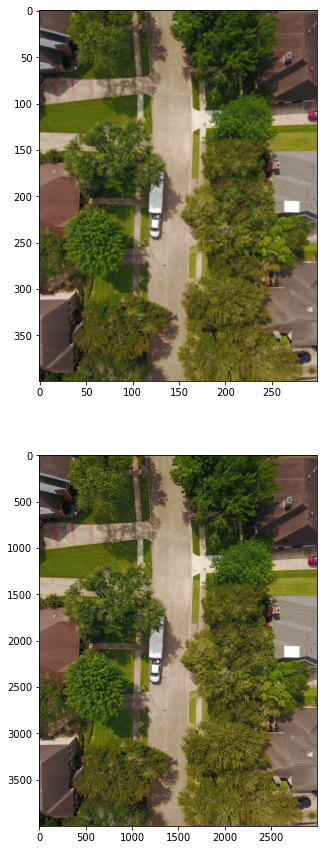

In [8]:
import torchvision.transforms as T

img_paths = sorted(glob.glob(config.TRAIN_IMG_PATH + "/*"))
img_path = img_paths[0]

img_vanilla = Image.open(img_path)
transform = T.Resize((400,300))
img = transform(img_vanilla)

f, ax = plt.subplots(2,1,figsize=(15, 15))
ax[0].imshow(img)
ax[1].imshow(img_vanilla)
plt.show()


### Resizing every image to a 400,300 shape

## Creating the folder

In [9]:
from pathlib import Path

destination = Path("/kaggle/working/small_dataset")
destination.mkdir()
train_dir = Path("/kaggle/working/small_dataset/train_images")
train_dir.mkdir()
test_dir = Path("/kaggle/working/small_dataset/test_images")
test_dir.mkdir()
mask_dir = Path("/kaggle/working/small_dataset/train_masks")
mask_dir.mkdir()

## Trainset

In [10]:
import tqdm 

img_paths = sorted(glob.glob(config.TRAIN_IMG_PATH + "/*"))
img_train_paths = sorted([Path(img) for img in img_paths])

for img_path in tqdm.tqdm(img_train_paths):
    img = Image.open(str(img_path))
    transform = T.Resize((400,300))
    img = transform(img)
    file_name= img_path.name
    img.save(train_dir / file_name)

100%|██████████| 261/261 [01:32<00:00,  2.81it/s]


## Testset

In [11]:
img_paths = sorted(glob.glob(config.TEST_IMG_PATH + "/*"))
img_test_paths = sorted([Path(img) for img in img_paths])

for img_path in tqdm.tqdm(img_test_paths):
    img = Image.open(str(img_path))
    transform = T.Resize((400,300))
    img = transform(img)
    file_name= img_path.name
    img.save(test_dir / file_name)

100%|██████████| 112/112 [00:39<00:00,  2.82it/s]


## Maskset

In [12]:
mask_path = sorted(glob.glob(config.TRAIN_MASK_PATH + "/*"))
img_mask_paths = sorted([Path(img) for img in mask_path])

for img_path in tqdm.tqdm(img_mask_paths):
    img = Image.open(str(img_path))
    transform = T.Resize((400,300))
    img = transform(img)
    file_name= img_path.name
    img.save(mask_dir / file_name)

100%|██████████| 261/261 [00:26<00:00,  9.74it/s]


# Augmentation

Example of mask usage from the new dataset

In [13]:
sorted(img_train_paths)[0]

PosixPath('/kaggle/input/msc-ai-2022/train_images/train_images/10172.jpg')

/kaggle/working/small_dataset/train_images/10174.jpg /kaggle/working/small_dataset/train_masks/10174.png


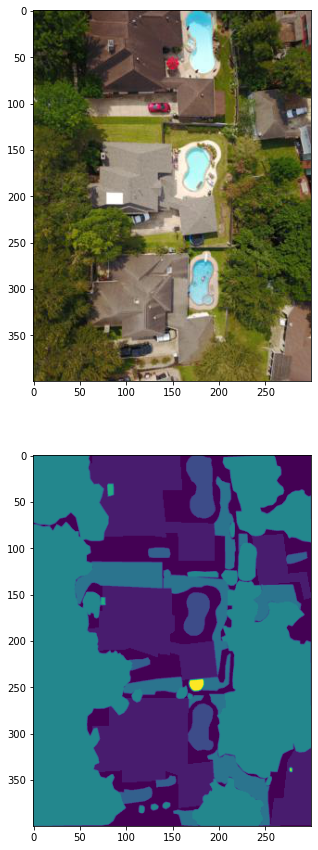

In [14]:
index = 1

img_paths = sorted(train_dir.glob('**/*'))
img_train_paths = sorted([Path(img) for img in img_paths])
img_path = img_train_paths[index]

mask_path = sorted(mask_dir.glob('**/*'))
img_mask_paths = sorted([Path(img) for img in mask_path])
mask_path = img_mask_paths[index]
print(img_path, mask_path)
img = Image.open(img_path)
mask = Image.open(mask_path)

f, ax = plt.subplots(2,1,figsize=(15, 15))
ax[0].imshow(img)
ax[1].imshow(mask)
plt.show()


### Example of transformation

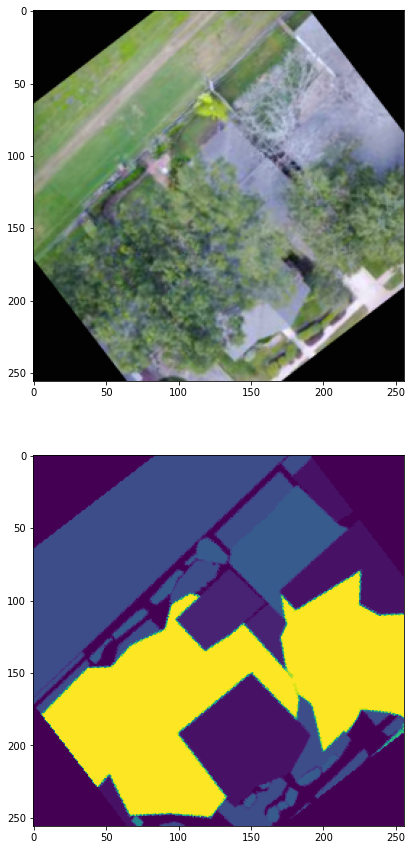

In [15]:
import cv2 
import albumentations as A

# Image and mask 
index = 12

img_paths = sorted(train_dir.glob('**/*'))
img_train_paths = sorted([Path(img) for img in img_paths])
img_path = img_train_paths[index]

mask_path = sorted(mask_dir.glob('**/*'))
img_mask_paths = sorted([Path(img) for img in mask_path])
mask_path = img_mask_paths[index]

img = Image.open(img_path)
mask = Image.open(mask_path)

# Transformation
transform = A.Compose(
    [
        A.RandomCrop(width=WIDTH, height=HEIGHT),
        A.Rotate(limit=40, p=0.9, border_mode=cv2.BORDER_CONSTANT),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
        A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.9),
        A.OneOf([
            A.Blur(blur_limit=3, p=0.5),
            A.ColorJitter(p=0.5),
        ], p=1.0),
    ]
)

#images_list = [img]
image = np.array(img)
mask = np.array(mask) # np.asarray(mask), np.array(mask)
augmentations = transform(image=image, masks=[mask])
augmented_img = augmentations["image"]
augmented_masks = augmentations["masks"]

f, ax = plt.subplots(2,1,figsize=(15, 15))
ax[0].imshow(augmented_img)
ax[1].imshow(augmented_masks[0])
plt.show()


In [42]:
from albumentations.pytorch import ToTensorV2

# Create a custom Dataset class
class tensorDataset(Dataset):
    def __init__(self, image_paths: list, mask_paths: list, train: bool, transform = None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.train = train
        self.transform =  A.Compose(
            [
                A.Resize(width=WIDTH, height=HEIGHT),
                A.RandomCrop(width=WIDTH, height=HEIGHT),
                A.Rotate(limit=40, p=0.9, border_mode=cv2.BORDER_CONSTANT),
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.1),
                A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.9),
                A.OneOf([
                    A.Blur(blur_limit=3, p=0.5),
                    A.ColorJitter(p=0.5),
                ], p=1.0),
                A.Normalize(
                    mean=[0, 0, 0],
                    std=[1, 1, 1],
                    max_pixel_value=255),
                ToTensorV2(),
            ]
        )
        
        
        
    def __getitem__(self, index):
        
        # Select a specific image's path
        img_path  = self.image_paths[index]
        mask_path = self.mask_paths[index]
        
        # Load the image
        img = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = np.array(img)
        mask = np.array(mask)

        augmentations = self.transform(image=image, mask = mask)
        augmented_img = augmentations["image"]
        augmented_mask = augmentations["mask"]
        
        return augmented_img, augmented_mask

    def __len__(self):
        return len(self.image_paths)

In [43]:
from albumentations.pytorch import ToTensorV2

img_paths = sorted(train_dir.glob('**/*'))
img_train_paths = sorted([Path(img) for img in img_paths])

mask_path = sorted(mask_dir.glob('**/*'))
img_mask_paths = sorted([Path(img) for img in mask_path])

train_dataset = tensorDataset(img_train_paths,img_mask_paths, train=True, transform = transform)

torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([

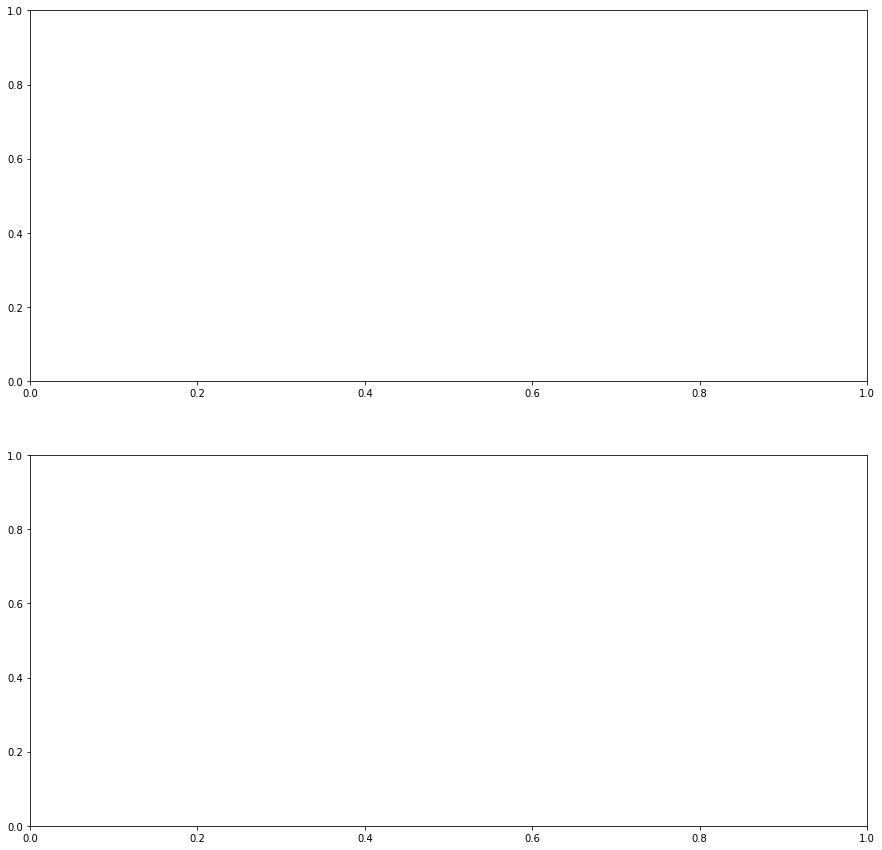

In [46]:
f, ax = plt.subplots(2,1,figsize=(15, 15))
for x,y in train_dataset:
    print(x.shape)

### Uploading dataset to kaggle

In [49]:
!cd /kaggle/input/identiti

In [55]:
!kaggle 

usage: kaggle [-h] [-v] {competitions,c,datasets,d,kernels,k,config} ...
kaggle: error: the following arguments are required: command


In [56]:
!kaggle datasets init -p /kaggle/working/small_dataset 

Data package template written to: /kaggle/working/small_dataset/dataset-metadata.json


In [76]:
import json

# Reading the file
path = Path("/kaggle/working/small_dataset/dataset-metadata.json")
f = open(path, "r")
data = json.loads(f.read())
print(data)

# modifying the file
data["title"]  = "small_dataset"
data["id"] = "adrienloizeau/Msc-AI-2022-small"

# erasing old file
path.unlink()

# creating a new file
with open(path, 'w') as f:
    json.dump(data, f)

{'title': 'small_dataset', 'id': 'adrienloizeau/Msc_AI_2022_small', 'licenses': [{'name': 'CC0-1.0'}]}


In [77]:
!kaggle datasets create -p /kaggle/working/small_dataset --dir-mode zip

Starting upload for file train_masks.zip
100%|██████████████████████████████████████| 2.27M/2.27M [00:00<00:00, 10.7MB/s]
Upload successful: train_masks.zip (2MB)
Starting upload for file test_images.zip
100%|██████████████████████████████████████| 2.28M/2.28M [00:00<00:00, 11.5MB/s]
Upload successful: test_images.zip (2MB)
Starting upload for file train_images.zip
100%|██████████████████████████████████████| 5.40M/5.40M [00:00<00:00, 27.0MB/s]
Upload successful: train_images.zip (5MB)
Your private Dataset is being created. Please check progress at https://www.kaggle.com/datasets/adrienloizeau/Msc-AI-2022-small


In [ ]:
...
# !kaggle datasets create -p /kaggle/working/small_dataset --dir-mode zip

# Dataset is available [here](https://www.kaggle.com/datasets/adrienloizeau/0feff4fbc0c2233153baa7b6c6c00815)